In [1]:
from mt.laser import get_func_gen_settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
on_time = off_time = np.linspace(0.01, 0.1, 100)
passes = np.arange(1, 11)

cycles = 7
time = 0.033 # s
settings_time = [get_func_gen_settings(time, time, cycles, 45, legacy=False) for time in on_time]
settings_passes = [get_func_gen_settings(time, time, p, 45, legacy=False) for p in passes]

setting_time = pd.DataFrame(settings_time)
settings_pass = pd.DataFrame(settings_passes)

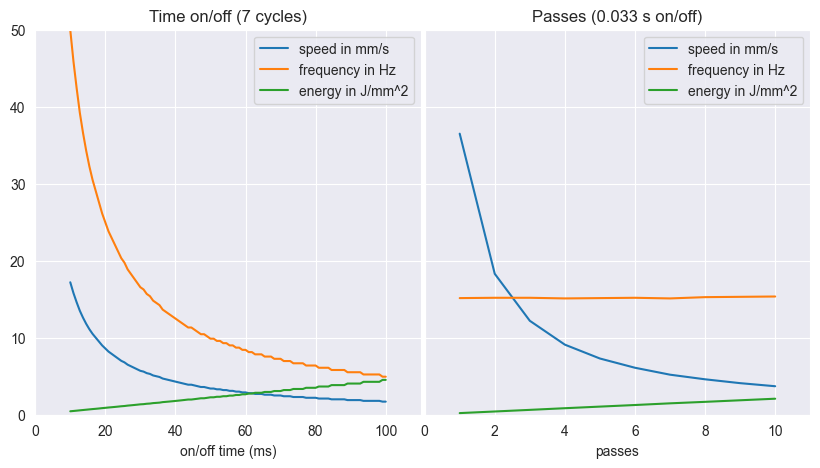

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0.01)
axs[0].plot(on_time*1e3, setting_time["speed"], label="speed in mm/s")
axs[0].plot(on_time*1e3, setting_time["frequency"], label="frequency in Hz")
axs[0].plot(on_time*1e3, setting_time["equivalent_energy"], label="energy in J/mm^2")
axs[0].axis([0, 110, 0, 50])
axs[0].set_xlabel("on/off time (ms)")
axs[0].legend()
axs[0].set_title("Time on/off ({} cycles)".format(cycles))

axs[1].plot(passes, settings_pass["speed"], label="speed in mm/s")
axs[1].plot(passes, settings_pass["frequency"], label="frequency in Hz")
axs[1].plot(passes, settings_pass["equivalent_energy"], label="energy in J/mm^2")
axs[1].axis([0, 11, 0, 50])
axs[1].set_xlabel("passes")
axs[1].legend()
axs[1].set_title("Passes ({} s on/off)".format(time))
plt.show()

Text(0.5, 1.0, 'Equivalent energy in J/mm^2')

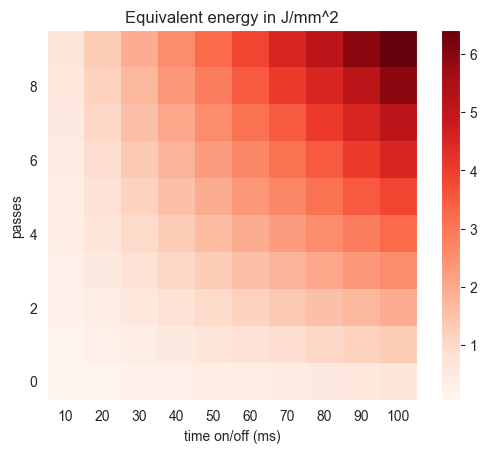

In [4]:
on_time = np.linspace(0.01, 0.1, 10)
passes = np.arange(1, 11)


settings = np.array([[get_func_gen_settings(time, time, p, 45, legacy=False)["equivalent_energy"] for time in on_time] for p in passes])


plt.imshow(settings, cmap="Reds", interpolation="nearest")
plt.colorbar()
plt.xlabel("time on/off (ms)")
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, 10, 1), ["{:.0f}".format(t*1e3) for t in on_time])
plt.ylabel("passes")
plt.grid(False)
plt.title("Equivalent energy in J/mm^2")

Assumptions for the equivalent energy calculation:
- The energy is assumed to be constant over the whole pulse duration.
- The entire laser power is absorbed by the material.
- The entire laser power is concentrated in the focal point of given spot size

Therefore, the equivalent energy is much larger than the actual energy delivered to the material.

In [5]:
from mt.laser import get_spot_size

def better_gen(on, off, n):
    error_v = 0.05
    S_x, S_y = get_spot_size(45)
    alpha = on/(on+off)
    f = 1/(on+off)
    v = S_y*f/n
    
    speed = np.round(S_y / (on + off) / n, 1)
    total_time_over_spot = S_y / speed
    frequency = n / total_time_over_spot
    total_time_on = total_time_over_spot * alpha
    single_time_on = total_time_on / n
    
    error_gauss = np.abs(-S_y*alpha/n * 1/(v**2) * error_v)/on*100
    error = (on-single_time_on)/on * 100
    
    return error, error_gauss


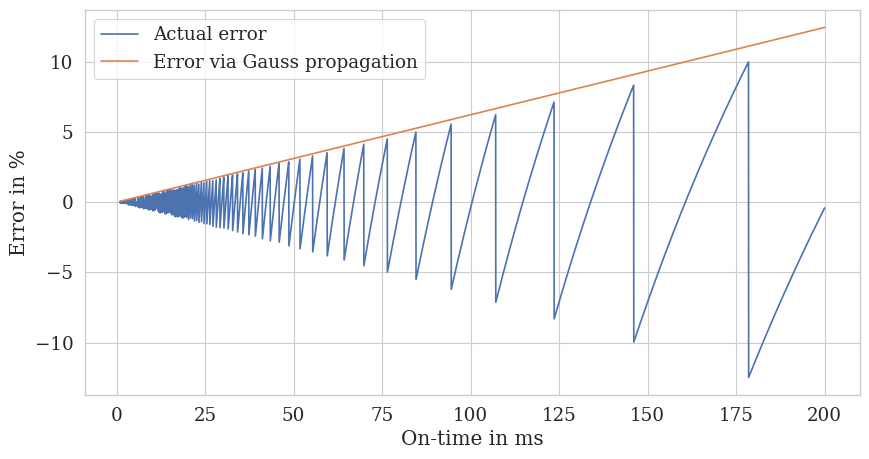

In [6]:
on_times = np.linspace(1e-3, 200e-3, 5000)
error, error_g = better_gen(on_times, 2*on_times, 10)
import seaborn as sns
sns.set_theme("paper", font_scale=1.5, font="serif", style="whitegrid")
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(on_times*1e3, error, label="Actual error")
plt.plot(on_times*1e3, error_g, label="Error via Gauss propagation")
plt.xlabel("On-time in ms")
plt.ylabel("Error in %")
plt.legend()
plt.savefig("../../05_Thesis/figures/Appendix/func_gen_error.pdf")

In [56]:
on = 25e-3
# s
off = 0.25*on # s
passes = 2.5


_ = get_func_gen_settings(on, off, passes, 45, legacy=False, verbose=True)
better_gen(on, off, passes)

Settings:
Set on time: 25 ms
Set off time: 6 ms
Cycles: 2.5
--------------------
Speed: 30.8 mm/s
Frequency: 31.95 Hz
Duty cycle: 80 %
Total time over spot: 0.08 s
Equivalent energy: 0.40 J/mm^2
--------------------
Actual on time: 25 ms
Total on time: 63 ms
Actual off time: 6 ms
Total off time: 16 ms


(np.float64(-0.15584415584414535), np.float64(0.1620850622406639))